In [2]:
#importing libraries for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import json
import math
import numpy as np

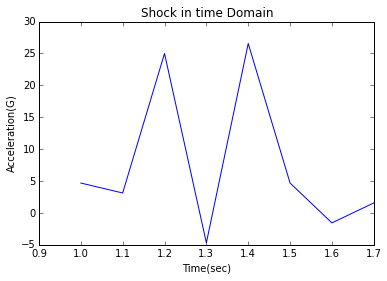

8  samples
10.0  samles/sec    0.1  sec
 Enter the amplification factor (typically Q=10) 10
0.05
 Select algorithm: 
 1=Kelly-Richman  2=Smallwood 1
 Calculating response..... 
omega 2.0944
2.0917803617
omega 2.21893950483
2.21616409473
omega 2.35088451398
2.34794406941
omega 2.49067538166
2.48756008916
omega 2.6387786469
2.63547810946
omega 2.79568859057
2.79219179297
omega 2.96192888503
2.95822415702
omega 3.13805434181
3.13412931921
omega 3.32465276324
3.32049434665
omega 3.52234690421
3.51794121531
omega 3.73179655055
3.72712888574
omega 3.95370072096
3.94875550236
omega 4.1888
4.1835607234
omega 4.43787900965
4.43232818946
omega 4.70176902796
4.69588813882
omega 4.98135076332
4.97512017832
omega 5.2775572938
5.27095621893
omega 5.59137718115
5.58438358594
omega 5.92385777007
5.91644831405
omega 6.27610868362
6.26825863842
omega 6.64930552648
6.6409886933
omega 7.04469380843
7.03588243061
omega 7.46359310109
7.45425777148
 Plotting output..... 
 Acceleration Shock Response Spectrum

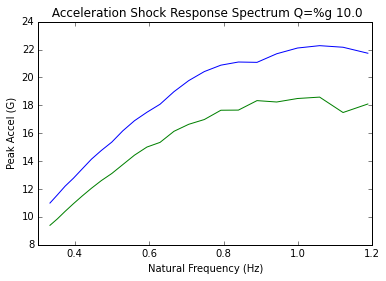

In [4]:
__author__ = 'Supriya'

import math
import numpy as np
from scipy.signal import lfilter
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3

# iunit = input(' Enter acceleration unit:   1= G   2= m/sec^2  ')
iunit = 1
t = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]  # TIME VECTOR
y = [4.6875, 3.125, 25, -4.6875, 26.5625, 4.6875, -1.5625, 1.5625]  # ACCELERATION VECTOR
plt1.plot(t, y)
plt1.xlabel('Time(sec)')
plt1.ylabel('Acceleration(G)')
plt1.title('Shock in time Domain')
plt1.show()

tmx = max(t)
tmi = min(t)
n = len(y)
nnn = n
print(n, " samples")
dt = (tmx - tmi) / (n - 1)
sr = 1. / dt
print(sr, " samles/sec   ", dt, " sec")

fn = [0] * 800
# fn[0]=input(' Enter the starting frequency (Hz)  ')
fn[0] = 1  # Frequency 1Hz
if fn[0] > sr / 30.:
    fn[0] = sr / 30.

Q = input(' Enter the amplification factor (typically Q=10) ')
damp = 1. / (2. * Q)
print(damp)

print(' Select algorithm: ')
ialgorithm = input(' 1=Kelly-Richman  2=Smallwood ')

tmax = (tmx - tmi) + 1. / fn[0]

limit = int(round(tmax / dt))
n = limit
yy = [0] * limit
for i in range(len(y)):
    yy[i] = y[i]

print(' Calculating response..... ')

l = 0
while l < 800:
    if fn[l] > sr / 8.:
        break
    if l < 799:
        fn[l + 1] = fn[0] * pow(2., ((l + 1) * (1. / 12.)))
    l = l + 1

a1 = [0] * l
a2 = [0] * l
b1 = [0] * l
b2 = [0] * l
b3 = [0] * l

rd_a1 = [0] * l
rd_a2 = [0] * l
rd_b1 = [0] * l
rd_b2 = [0] * l
rd_b3 = [0] * l

x_neg = [0] * l
x_pos = [0] * l
x_std = [0] * l
rd_neg = [0] * l
rd_pos = [0] * l
pi = 3.1416

for j in range(l):

    omega = 2. * pi * fn[j]
    print("omega", omega)
    omegad = omega * math.sqrt(1. - (pow(damp, 2)))
    print(omegad)
    cosd = math.cos(omegad * dt)
    sind = math.sin(omegad * dt)
    domegadt = damp * omega * dt
    # rd_a1[j]=2.*math.exp(-domegadt)*cosd
    # rd_a2[j]=-math.exp(-2.*domegadt)
    # rd_b1[j]=0.
    # rd_b2[j]=-(dt/omegad)*math.exp(-domegadt)*sind
    # rd_b3[j]=0

    if ialgorithm == 1:
        a1[j] = 2. * math.exp(-domegadt) * cosd
        a2[j] = -math.exp(-2. * domegadt)
        b1[j] = 2. * domegadt
        b2[j] = omega * dt * math.exp(-domegadt)
        b2[j] *= (omega / omegad) * (1. - 2. * (pow(damp, 2))) * sind - 2. * damp * cosd
        b3[j] = 0

    else:
        E = math.exp(-damp * omega * dt)
        K = omegad * dt
        C = E * math.cos(K)
        S = E * math.sin(K)
        Sp = S / K
        a1[j] = 2 * C
        a2[j] = -(pow(E, 2))
        b1[j] = 1. - Sp
        b2[j] = 2. * (Sp - C)
        b3[j] = pow(E, 2) - Sp

    forward = [b1[j], b2[j], b3[j]]
    back = [1, -a1[j], -a2[j]]

    resp = lfilter(forward, back, yy)
    x_pos[j] = max(resp)
    x_neg[j] = min(resp)
    x_std[j] = np.std(resp)

    rd_forward = [rd_b1[j], rd_b2[j], rd_b3[j]]
    rd_back = [1, -rd_a1[j], -rd_a2[j]]

    rd_resp = lfilter(rd_forward, rd_back, yy)

    rd_pos[j] = max(rd_resp)
    rd_neg[j] = min(rd_resp)

    # Relative Displacement

    jnum = j
    # if  fn[j] > sr/8.:
    #     break
    # if j<799:
    #     fn[j+1]=fn[1]*pow(2.,(j*(1./12.)))

tmax = (tmx - tmi)

print(' Plotting output..... ')

#  Find limits for plot

srs_max = max(x_pos)
if max(abs(i) for i in x_neg) > srs_max:
    srs_max = max(abs(i) for i in x_neg)

maximaxSRS = srs_max

srs_min = min(x_pos)
if min(abs(i) for i in x_neg) < srs_min:
    srs_min = min(abs(i) for i in x_neg)

Q = 1. / (2. * damp);
out5 = ' Acceleration Shock Response Spectrum Q=%g ' + str(Q)
print(out5)

ymax = math.pow(10, (int(round(np.log10(srs_max) + 0.8))))
ymin = math.pow(10, (int(round(np.log10(srs_min) - 0.6))))

fmax = max(fn);
fmin = fmax / 10.;

fmax = math.pow(10, (int(round(np.log10(fmax) + 0.5))))

fmin = 0.1

x_neg_abs = [0] * len(x_neg)
for i in range(len(x_neg)):
    x_neg_abs[i] = abs(x_neg[i])

fn1 = [0] * l
for i in range(l):
    fn1[i] = fn[i]

# fn1 = np.array(fn)
# x_pos1 =np.array(x_pos)
# x_neg_abs1 =np.array(x_neg_abs)

plt2.plot(fn1, x_pos, fn1, x_neg_abs)
plt2.title(out5)
plt2.xlabel('Natural Frequency (Hz)')
plt2.ylabel('Peak Accel (G)')
# plt2.axis([fmin, fmax, ymin, ymax])
plt2.show()